# Perfectly Stirred Reactor

This example is a simplified version of a notebook simulating _Varying Residence Time to Extinction_ (see [GitHub](https://github.com/Cantera/essci-2018-materials/blob/master/0D_psr.ipynb)), which also contains supplementary information.

In [1]:
%matplotlib notebook

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

### Problem Setup

In [2]:
taus = np.logspace(-0, -4, num=200)
phi = 1.
p = 1.
volume = .05e-3 # reactor volume (in m^3)

def mdot(t):
    return reac.mass/res_time

gas = ct.Solution('gri30.xml')
CO_index = gas.species_index('CO')
CH4_index = gas.species_index('CH4')

### Loop over Residence Times

In each case, integrate to steady state. If three integrations in a row result in blow-off ($T<500$ K), stop integration.

In [3]:
Ts = np.nan * np.zeros_like(taus)
COs = np.nan * np.zeros_like(taus)
CH4s = np.nan * np.zeros_like(taus)
mdots = np.nan * np.zeros_like(taus)

count = 0
for i, res_time in enumerate(taus):
    
    gas.set_equivalence_ratio(phi, 'CH4', {'O2': 1.0, 'N2': 3.76})
    gas.TP = 300, p*ct.one_atm

    upstream = ct.Reservoir(gas)
    downstream = ct.Reservoir(gas)
    gas.equilibrate('hp')
    reac = ct.IdealGasReactor(gas)
    reac.volume = volume
    outlet = ct.MassFlowController(reac, downstream)
    outlet.set_mass_flow_rate(mdot)
    inlet = ct.Valve(upstream, reac, K=100*volume)
    netw = ct.ReactorNet([reac])

    try:
        netw.advance_to_steady_state()
    except ct.CanteraError:
        pass
    else:
        Ts[i] = reac.T
        COs[i] = gas.X[CO_index]
        CH4s[i] = gas.X[CH4_index]
        mdots[i] = outlet.mdot(res_time)
        if reac.T < 500:
            count += 1
        else:
            count = 0
        if count == 3:
            break

### Results

<IPython.core.display.Javascript object>


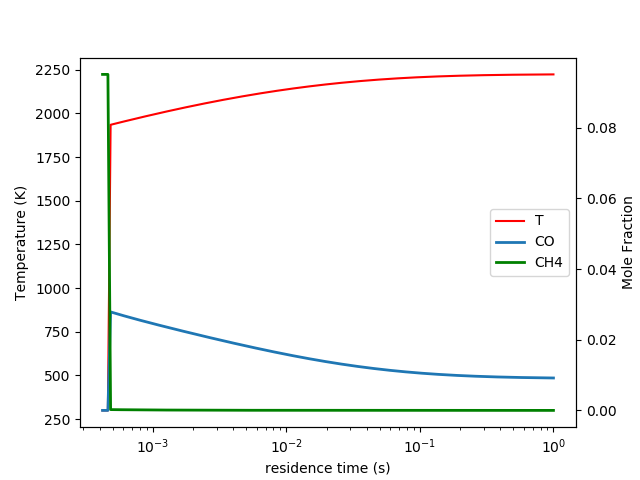

In [4]:
# in terms of residence time
L1 = plt.semilogx(taus,Ts,'r', label='T')
plt.xlabel('residence time (s)')
plt.ylabel('Temperature (K)')
plt.twinx()
L2 = plt.plot(taus, COs, label='CO', lw=2)
L3 = plt.plot(taus, CH4s, 'g', label='CH4', lw=2)
plt.ylabel('Mole Fraction')
_ = plt.legend(L1+L2+L3, [line.get_label() for line in L1+L2+L3], loc='right')    

<IPython.core.display.Javascript object>


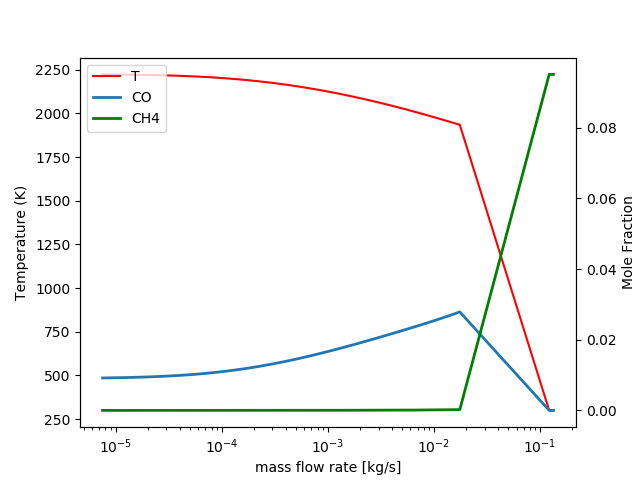

In [14]:
# in terms of mass flow rate
plt.figure()
L1 = plt.semilogx(mdots,Ts,'r', label='T')
plt.xlabel('mass flow rate [kg/s]')
plt.ylabel('Temperature (K)')
plt.twinx()
L2 = plt.plot(mdots, COs, label='CO', lw=2)
L3 = plt.plot(mdots, CH4s, 'g', label='CH4', lw=2)
plt.ylabel('Mole Fraction')
_ = plt.legend(L1+L2+L3, [line.get_label() for line in L1+L2+L3], loc='best')    